In [1]:

# # Task 3: Embedding Space Analysis
# 
# **Objective**: Quantify perturbation effects in learned embedding space and identify disease-to-healthy shifts
# 
# ## Background
# 
# This analysis uses the Geneformer embeddings from Task 2 to measure how genetic perturbations 
# affect cellular states in ALS. We employ two complementary distance metrics:
# 
# - **Euclidean Distance**: Measures magnitude of movement in embedding space (how far cells move)
# - **Cosine Distance**: Measures directional change (angular shift in gene expression patterns)
# 
# **Why both metrics?** The Geneformer paper (Nature 2023) demonstrates that cosine similarity 
# better captures transcriptional relationships for ranking gene perturbation effects, as it focuses 
# on the direction of change rather than magnitude. However, Euclidean distance provides complementary 
# information about the scale of cellular state changes, which is important for assessing therapeutic 
# potential.
# 
# ## Key Metrics Computed
# 
# 1. **Population Shifts**: Centroid movement (Euclidean & Cosine)
# 2. **Structure Preservation**: Local neighborhood retention
# 3. **Disease Rescue Potential**: ALS → PN (healthy) distance changes

## 1. Setup and Data Loading

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import yaml
from scipy.spatial.distance import euclidean, cosine

# Path handling
NOTEBOOK_DIR = Path.cwd()
PROJECT_ROOT = NOTEBOOK_DIR.parent if NOTEBOOK_DIR.name == 'notebooks' else NOTEBOOK_DIR

import sys
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

from utils.embeddings import EmbeddingAnalyzer
from utils.data_io import DataIOManager
from utils import visualization as viz

print(f"Project root: {PROJECT_ROOT}")

Project root: /Users/lubainakothari/Desktop/perturbation_newstructure


In [3]:
# Load configuration
config_path = PROJECT_ROOT / "config" / "config.yaml"
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

RANDOM_SEED = config['random_seed']
np.random.seed(RANDOM_SEED)

# Define paths
CACHE_DIR = PROJECT_ROOT / config['data']['cache_dir']
RESULTS_DIR = PROJECT_ROOT / config['data']['results_dir']
TASK2_DIR = RESULTS_DIR / "task2"
TASK3_DIR = RESULTS_DIR / "task3"
TABLES_DIR = TASK3_DIR / "tables"
FIGURES_DIR = TASK3_DIR / "figures"

# Create output directories
for d in [TASK3_DIR, TABLES_DIR, FIGURES_DIR]:
    d.mkdir(parents=True, exist_ok=True)

# Set visualization defaults
plt.rcParams['figure.dpi'] = config['visualization']['figure_dpi']
sns.set_style("whitegrid")

print(f"Output directory: {TASK3_DIR}")

Output directory: /Users/lubainakothari/Desktop/perturbation_newstructure/results/task3


In [4]:
# Load Task 2 outputs (embeddings and metadata)
print("\nLoading Geneformer embeddings from Task 2...")

io_manager = DataIOManager(base_dir=str(PROJECT_ROOT / "data"), cache_dir=str(CACHE_DIR))

# Load embeddings
embeddings_dict = io_manager.load_embeddings_hdf5("task2_all_embeddings.h5")
baseline_embeddings = embeddings_dict.pop('baseline')  # ALS baseline state
perturbation_embeddings = embeddings_dict  # All perturbations

# Load metadata
metadata = pd.read_csv(TASK2_DIR / "tables" / "perturbation_metadata.csv")

print(f"Baseline: {baseline_embeddings.shape} (cells × embedding_dim)")
print(f"Perturbations: {len(perturbation_embeddings)}")
print(f"Metadata: {len(metadata)} perturbations")


Loading Geneformer embeddings from Task 2...
DataIOManager initialized
  Data directory: /Users/lubainakothari/Desktop/perturbation_newstructure/data
  Cache directory: /Users/lubainakothari/Desktop/perturbation_newstructure/cache
Loading embeddings from: /Users/lubainakothari/Desktop/perturbation_newstructure/cache/task2_all_embeddings.h5


Loading: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 405.79it/s]

✓ Loaded 27 embedding sets
Baseline: (50, 512) (cells × embedding_dim)
Perturbations: 26
Metadata: 24 perturbations


## 2. Define Reference States

**ALS Baseline**: Starting disease state (from baseline_embeddings)

**PN Reference**: Healthy motor neuron state (computed from PN perturbation centroids)

We use the PN (proximal neuron) condition as our "healthy" reference to quantify disease rescue.

In [5]:
# Separate perturbations by condition
als_perts = metadata[metadata['condition'] == 'ALS']
pn_perts = metadata[metadata['condition'] == 'PN']

# Compute baseline centroid (ALS disease state)
baseline_centroid = baseline_embeddings.mean(axis=0)

# Compute PN reference (healthy state) from PN perturbation centroids
pn_embeddings = [perturbation_embeddings[pid] for pid in pn_perts['perturbation_id'].values]
pn_reference = np.mean(np.vstack(pn_embeddings), axis=0)

print(f"Baseline (ALS) centroid: {baseline_centroid.shape}")
print(f"PN (healthy) reference: {pn_reference.shape}")
print(f"\nALS perturbations: {len(als_perts)}")
print(f"PN perturbations: {len(pn_perts)}")

Baseline (ALS) centroid: (512,)
PN (healthy) reference: (512,)

ALS perturbations: 12
PN perturbations: 12


## 3. Comprehensive Embedding Analysis

For each perturbation, compute:
- **Centroid shift** (Euclidean): Magnitude of population movement
- **Cosine shift**: Angular/directional change in embedding space
- **Mean cell shift**: Average per-cell movement
- **Neighborhood preservation**: % of k-nearest neighbors retained

In [6]:
print("\nComputing embedding metrics...")

analyzer = EmbeddingAnalyzer(
    baseline_embeddings=baseline_embeddings,
    perturbation_embeddings=perturbation_embeddings,
    metadata=metadata
)

# Compute all metrics
analysis_results = analyzer.analyze_all(k_neighbors=10)

print(f"\nAnalysis complete: {len(analysis_results)} perturbations")
print(f"\nMetric ranges:")
print(f"  Centroid shift (Euclidean): {analysis_results['centroid_shift'].min():.4f} - {analysis_results['centroid_shift'].max():.4f}")
print(f"  Cosine shift:               {analysis_results['cosine_shift'].min():.4f} - {analysis_results['cosine_shift'].max():.4f}")
print(f"  Neighborhood preservation:  {analysis_results['neighborhood_preservation'].min():.4f} - {analysis_results['neighborhood_preservation'].max():.4f}")

# Save results
analysis_results.to_csv(TABLES_DIR / "embedding_metrics.csv", index=False)
print(f"\nSaved: embedding_metrics.csv")


Computing embedding metrics...
EmbeddingAnalyzer initialized
  Baseline: 50 cells
  Perturbations: 26
Analyzing 26 perturbations...
  [1/26] KD_DMD_0.2_ALS
  [2/26] KD_DMD_0.2_PN
  [3/26] KD_DMD_0.5_ALS
  [4/26] KD_DMD_0.5_PN
  [5/26] KD_KHDRBS2_0.2_ALS
  [6/26] KD_KHDRBS2_0.2_PN
  [7/26] KD_KHDRBS2_0.5_ALS
  [8/26] KD_KHDRBS2_0.5_PN
  [9/26] KD_MAP1B_0.2_ALS
  [10/26] KD_MAP1B_0.2_PN
  [11/26] KD_MAP1B_0.5_ALS
  [12/26] KD_MAP1B_0.5_PN
  [13/26] KU_DMD_2.0_ALS
  [14/26] KU_DMD_2.0_PN
  [15/26] KU_DMD_3.0_ALS
  [16/26] KU_DMD_3.0_PN
  [17/26] KU_KHDRBS2_2.0_ALS
  [18/26] KU_KHDRBS2_2.0_PN
  [19/26] KU_KHDRBS2_3.0_ALS
  [20/26] KU_KHDRBS2_3.0_PN
  [21/26] KU_MAP1B_2.0_ALS
  [22/26] KU_MAP1B_2.0_PN
  [23/26] KU_MAP1B_3.0_ALS
  [24/26] KU_MAP1B_3.0_PN
  [25/26] als_baseline
  [26/26] pn_baseline
✓ Analysis complete: 24 perturbations

Analysis complete: 24 perturbations

Metric ranges:
  Centroid shift (Euclidean): 0.0071 - 0.0547
  Cosine shift:               0.0000 - 0.0024
  Neighborho

### 3.1 Compare Euclidean vs Cosine Methods

**Why compare?** 
- Euclidean captures scale (large vs small state changes)
- Cosine captures direction (what type of transcriptional program is activated)
- High correlation suggests perturbations that move cells far also redirect their identity
- Low correlation suggests some perturbations subtly redirect without large movements

In [7]:
print("\n" + "="*70)
print("EUCLIDEAN VS COSINE SHIFT COMPARISON")
print("="*70)

# Calculate correlation
corr = analysis_results['centroid_shift'].corr(analysis_results['cosine_shift'])
print(f"\nPearson correlation: {corr:.3f}")

# Top 10 by Euclidean distance
print("\nTop 10 by Centroid Shift (Euclidean - measures magnitude):")
top_euclidean = analysis_results.nlargest(10, 'centroid_shift')[
    ['perturbation_id', 'gene', 'type', 'factor', 'centroid_shift', 'cosine_shift']
]
for i, (_, row) in enumerate(top_euclidean.iterrows(), 1):
    type_short = 'KD' if row['type'] == 'knock_down' else 'KU'
    factor_str = f"{row['factor']:.1f}" if pd.notna(row['factor']) else "?"
    print(f"  {i:2d}. {type_short}_{row['gene']:12s}_{factor_str:>4s} | "
          f"Euclidean={row['centroid_shift']:.4f}, Cosine={row['cosine_shift']:.4f}")

# Top 10 by Cosine distance
print("\nTop 10 by Cosine Shift (measures directional change):")
top_cosine = analysis_results.nlargest(10, 'cosine_shift')[
    ['perturbation_id', 'gene', 'type', 'factor', 'centroid_shift', 'cosine_shift']
]
for i, (_, row) in enumerate(top_cosine.iterrows(), 1):
    type_short = 'KD' if row['type'] == 'knock_down' else 'KU'
    factor_str = f"{row['factor']:.1f}" if pd.notna(row['factor']) else "?"
    print(f"  {i:2d}. {type_short}_{row['gene']:12s}_{factor_str:>4s} | "
          f"Euclidean={row['centroid_shift']:.4f}, Cosine={row['cosine_shift']:.4f}")

# Check overlap
euc_ids = set(top_euclidean['perturbation_id'])
cos_ids = set(top_cosine['perturbation_id'])
overlap = len(euc_ids.intersection(cos_ids))
print(f"\nOverlap: {overlap}/10 perturbations in both top 10 lists")


EUCLIDEAN VS COSINE SHIFT COMPARISON

Pearson correlation: 0.971

Top 10 by Centroid Shift (Euclidean - measures magnitude):
   1. KD_DMD         _ 0.2 | Euclidean=0.0547, Cosine=0.0024
   2. KD_MAP1B       _ 0.2 | Euclidean=0.0417, Cosine=0.0015
   3. KD_DMD         _ 0.2 | Euclidean=0.0414, Cosine=0.0015
   4. KD_DMD         _ 0.5 | Euclidean=0.0342, Cosine=0.0010
   5. KD_MAP1B       _ 0.2 | Euclidean=0.0335, Cosine=0.0010
   6. KD_KHDRBS2     _ 0.2 | Euclidean=0.0323, Cosine=0.0008
   7. KD_MAP1B       _ 0.5 | Euclidean=0.0323, Cosine=0.0009
   8. KD_MAP1B       _ 0.5 | Euclidean=0.0270, Cosine=0.0006
   9. KU_KHDRBS2     _ 3.0 | Euclidean=0.0230, Cosine=0.0004
  10. KU_DMD         _ 3.0 | Euclidean=0.0218, Cosine=0.0004

Top 10 by Cosine Shift (measures directional change):
   1. KD_DMD         _ 0.2 | Euclidean=0.0547, Cosine=0.0024
   2. KD_MAP1B       _ 0.2 | Euclidean=0.0417, Cosine=0.0015
   3. KD_DMD         _ 0.2 | Euclidean=0.0414, Cosine=0.0015
   4. KD_DMD         _ 0.5

## 4. Disease Rescue Analysis (ALS → PN)

**Rescue Score**: Change in distance from ALS baseline to PN (healthy) reference

- **Negative score** = Perturbation moves cells TOWARD healthy state (therapeutic potential)
- **Positive score** = Perturbation moves cells AWAY from healthy state (detrimental)

We compute rescue scores using both Euclidean and Cosine distances.

In [8]:
print("\n" + "="*70)
print("DISEASE RESCUE ANALYSIS (ALS → PN)")
print("="*70)

# For each ALS perturbation, compute rescue potential
rescue_analysis = []

for _, row in als_perts.iterrows():
    pert_id = row['perturbation_id']
    pert_emb = perturbation_embeddings[pert_id]
    pert_centroid = pert_emb.mean(axis=0)
    
    # Euclidean rescue score
    baseline_to_pn = euclidean(baseline_centroid, pn_reference)
    pert_to_pn = euclidean(pert_centroid, pn_reference)
    rescue_score_euc = pert_to_pn - baseline_to_pn  # Negative = moves toward PN
    
    # Cosine rescue score
    baseline_to_pn_cos = cosine(baseline_centroid, pn_reference)
    pert_to_pn_cos = cosine(pert_centroid, pn_reference)
    rescue_score_cos = pert_to_pn_cos - baseline_to_pn_cos
    
    rescue_analysis.append({
        'perturbation_id': pert_id,
        'gene': row['gene'],
        'type': row['type'],
        'factor': row['factor'],
        'rescue_score': rescue_score_euc,
        'rescue_score_cosine': rescue_score_cos,
        'moves_toward_healthy': rescue_score_euc < 0,
        'moves_toward_healthy_cosine': rescue_score_cos < 0
    })

rescue_df = pd.DataFrame(rescue_analysis)

print(f"\nAnalyzed {len(rescue_df)} ALS perturbations")
print(f"\nEuclidean rescue:")
print(f"  Toward PN (therapeutic):  {rescue_df['moves_toward_healthy'].sum()}")
print(f"  Away from PN (harmful):   {(~rescue_df['moves_toward_healthy']).sum()}")
print(f"\nCosine rescue:")
print(f"  Toward PN (therapeutic):  {rescue_df['moves_toward_healthy_cosine'].sum()}")
print(f"  Away from PN (harmful):   {(~rescue_df['moves_toward_healthy_cosine']).sum()}")

# Top 5 rescue candidates by each method
print(f"\nTop 5 rescue candidates (Euclidean):")
top_rescue_euc = rescue_df.nsmallest(5, 'rescue_score')
for i, (_, row) in enumerate(top_rescue_euc.iterrows(), 1):
    print(f"  {i}. {row['perturbation_id']:30s} | "
          f"Euc={row['rescue_score']:>7.4f}, Cos={row['rescue_score_cosine']:>7.4f}")

print(f"\nTop 5 rescue candidates (Cosine):")
top_rescue_cos = rescue_df.nsmallest(5, 'rescue_score_cosine')
for i, (_, row) in enumerate(top_rescue_cos.iterrows(), 1):
    print(f"  {i}. {row['perturbation_id']:30s} | "
          f"Euc={row['rescue_score']:>7.4f}, Cos={row['rescue_score_cosine']:>7.4f}")

# Method agreement
euc_rescue_ids = set(top_rescue_euc['perturbation_id'])
cos_rescue_ids = set(top_rescue_cos['perturbation_id'])
rescue_overlap = len(euc_rescue_ids.intersection(cos_rescue_ids))
print(f"\nOverlap: {rescue_overlap}/5 in both top 5 lists")

# Save results
rescue_df.to_csv(TABLES_DIR / "disease_rescue_analysis.csv", index=False)
print(f"\nSaved: disease_rescue_analysis.csv")


DISEASE RESCUE ANALYSIS (ALS → PN)

Analyzed 12 ALS perturbations

Euclidean rescue:
  Toward PN (therapeutic):  2
  Away from PN (harmful):   10

Cosine rescue:
  Toward PN (therapeutic):  1
  Away from PN (harmful):   11

Top 5 rescue candidates (Euclidean):
  1. KD_KHDRBS2_0.5_ALS             | Euc=-0.0029, Cos=-0.0001
  2. KD_MAP1B_0.5_ALS               | Euc=-0.0002, Cos= 0.0000
  3. KD_DMD_0.5_ALS                 | Euc= 0.0004, Cos= 0.0000
  4. KU_KHDRBS2_2.0_ALS             | Euc= 0.0005, Cos= 0.0000
  5. KU_KHDRBS2_3.0_ALS             | Euc= 0.0018, Cos= 0.0001

Top 5 rescue candidates (Cosine):
  1. KD_KHDRBS2_0.5_ALS             | Euc=-0.0029, Cos=-0.0001
  2. KD_MAP1B_0.5_ALS               | Euc=-0.0002, Cos= 0.0000
  3. KD_DMD_0.5_ALS                 | Euc= 0.0004, Cos= 0.0000
  4. KU_KHDRBS2_2.0_ALS             | Euc= 0.0005, Cos= 0.0000
  5. KU_KHDRBS2_3.0_ALS             | Euc= 0.0018, Cos= 0.0001

Overlap: 5/5 in both top 5 lists

Saved: disease_rescue_analysis.csv


## 5. Merge Results

Combine all analyses into a single comprehensive table

In [9]:
# Merge rescue scores with main analysis (ALS perturbations only)
full_results = analysis_results.merge(
    rescue_df[['perturbation_id', 'rescue_score', 'rescue_score_cosine', 'moves_toward_healthy']], 
    on='perturbation_id', 
    how='left'
)

full_results.to_csv(TABLES_DIR / "full_analysis.csv", index=False)
print(f"Full results saved: {len(full_results)} perturbations")

Full results saved: 24 perturbations


## 6. Visualizations

In [10]:
print("\n" + "="*70)
print("GENERATING VISUALIZATIONS")
print("="*70)


GENERATING VISUALIZATIONS



1. Metrics heatmap (top 20 perturbations)...


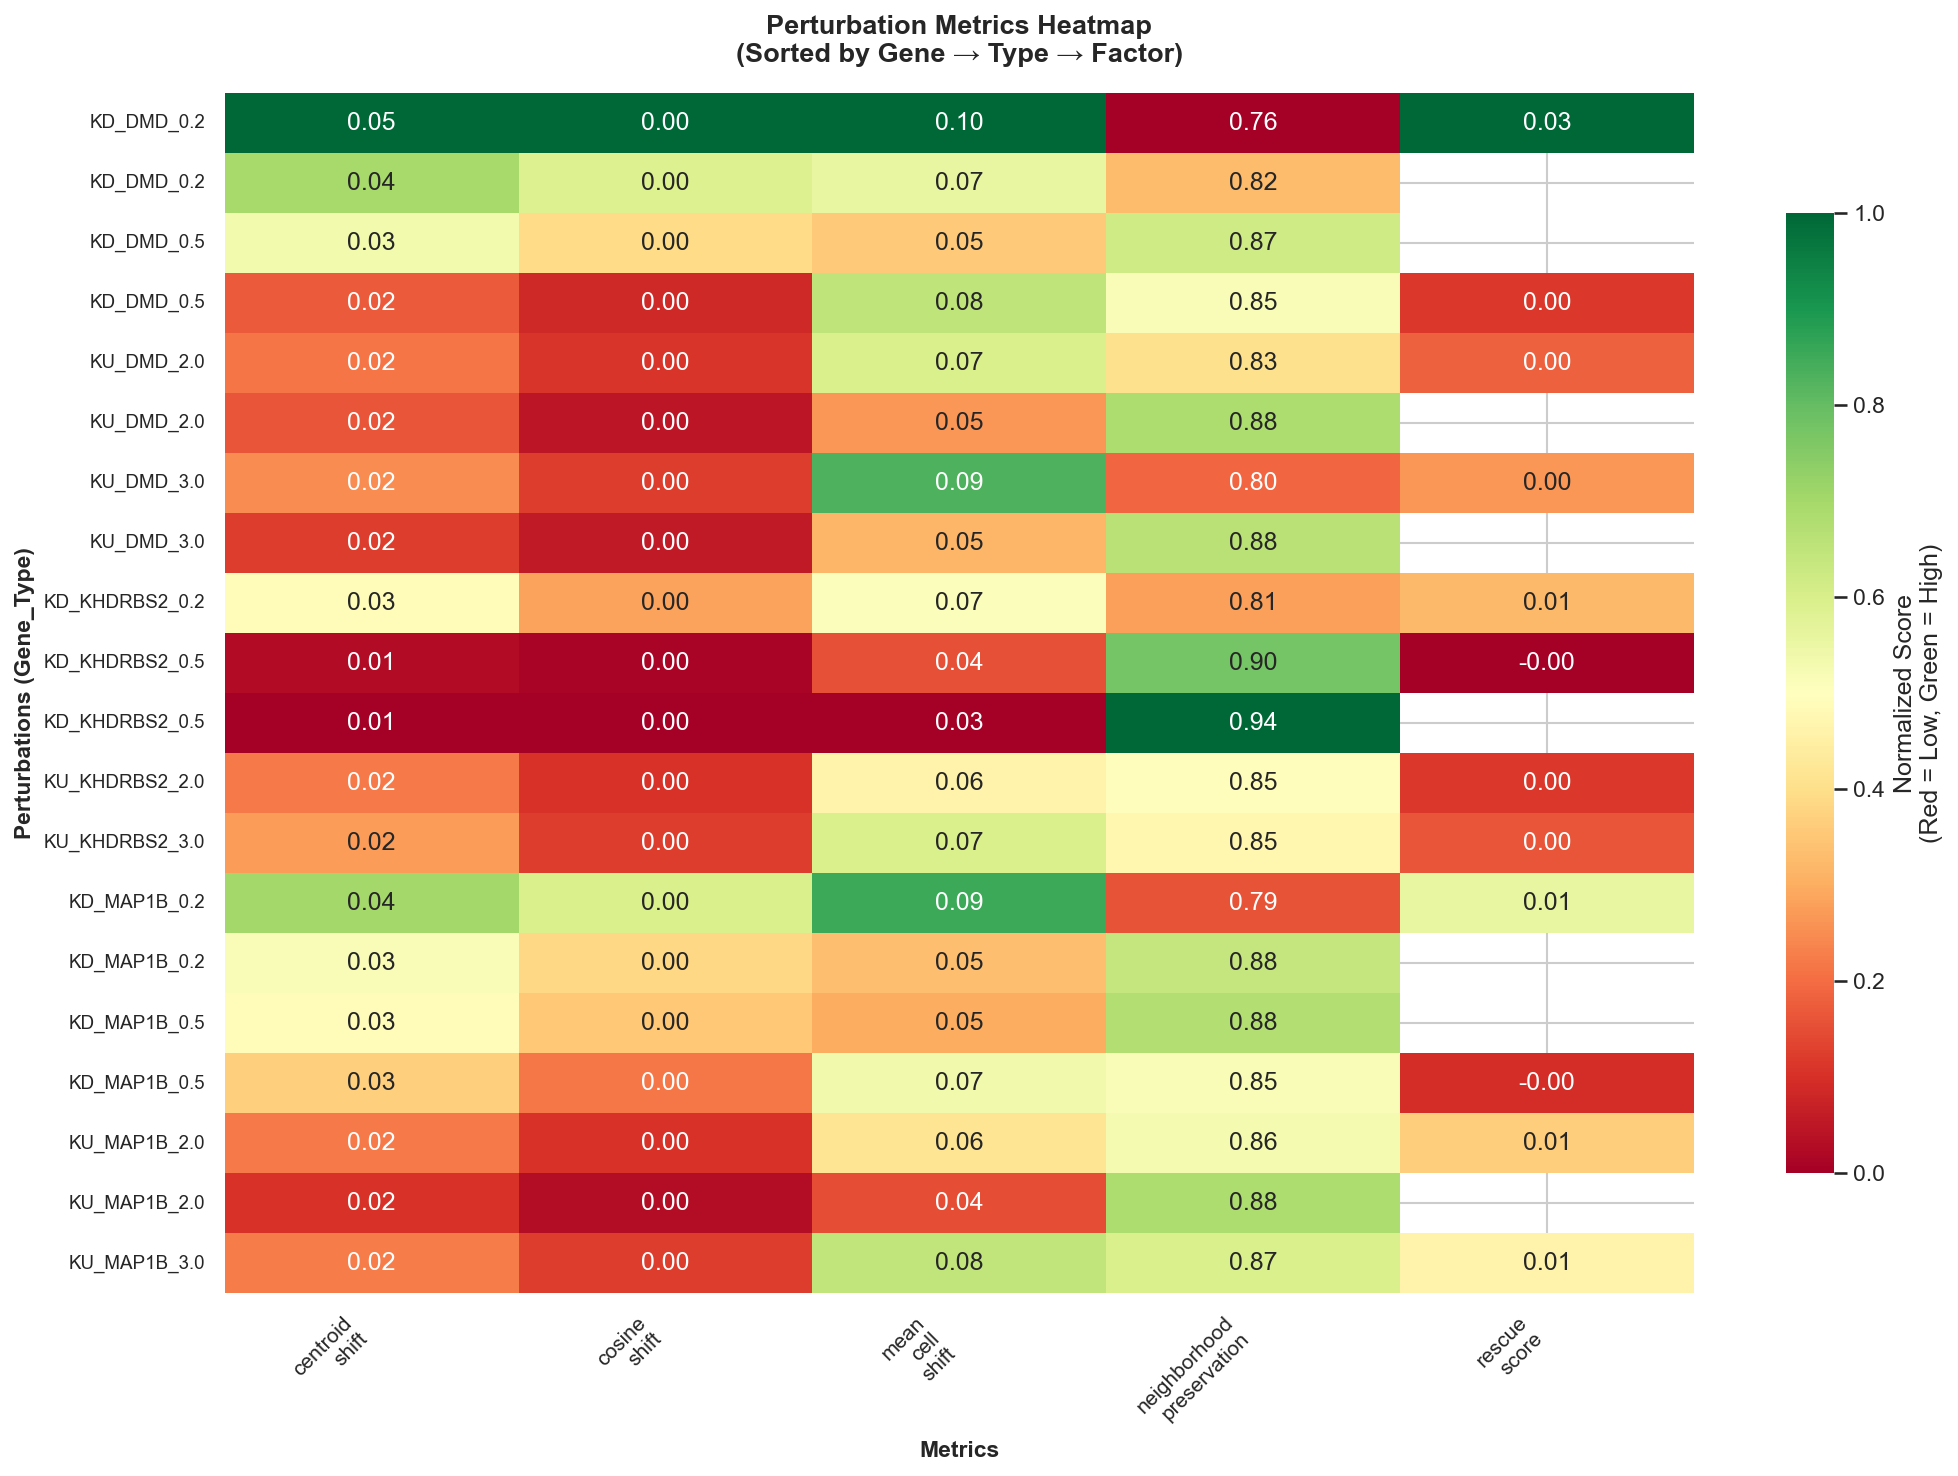

   Saved: metrics_heatmap.png


In [11]:
# Visualization 1: Metrics Heatmap
print("\n1. Metrics heatmap (top 20 perturbations)...")

heatmap_data = full_results.nlargest(20, 'centroid_shift').copy()
heatmap_metrics = ['centroid_shift', 'cosine_shift', 'mean_cell_shift', 'neighborhood_preservation']

# Add rescue score for ALS perturbations
if 'rescue_score' in heatmap_data.columns:
    heatmap_data_als = heatmap_data.dropna(subset=['rescue_score'])
    if len(heatmap_data_als) > 0:
        heatmap_metrics.append('rescue_score')

fig = viz.plot_metrics_heatmap(heatmap_data, metrics=heatmap_metrics, figsize=(14, 10))
plt.savefig(FIGURES_DIR / 'metrics_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()
print("   Saved: metrics_heatmap.png")


2. Comparing Euclidean vs Cosine methods...


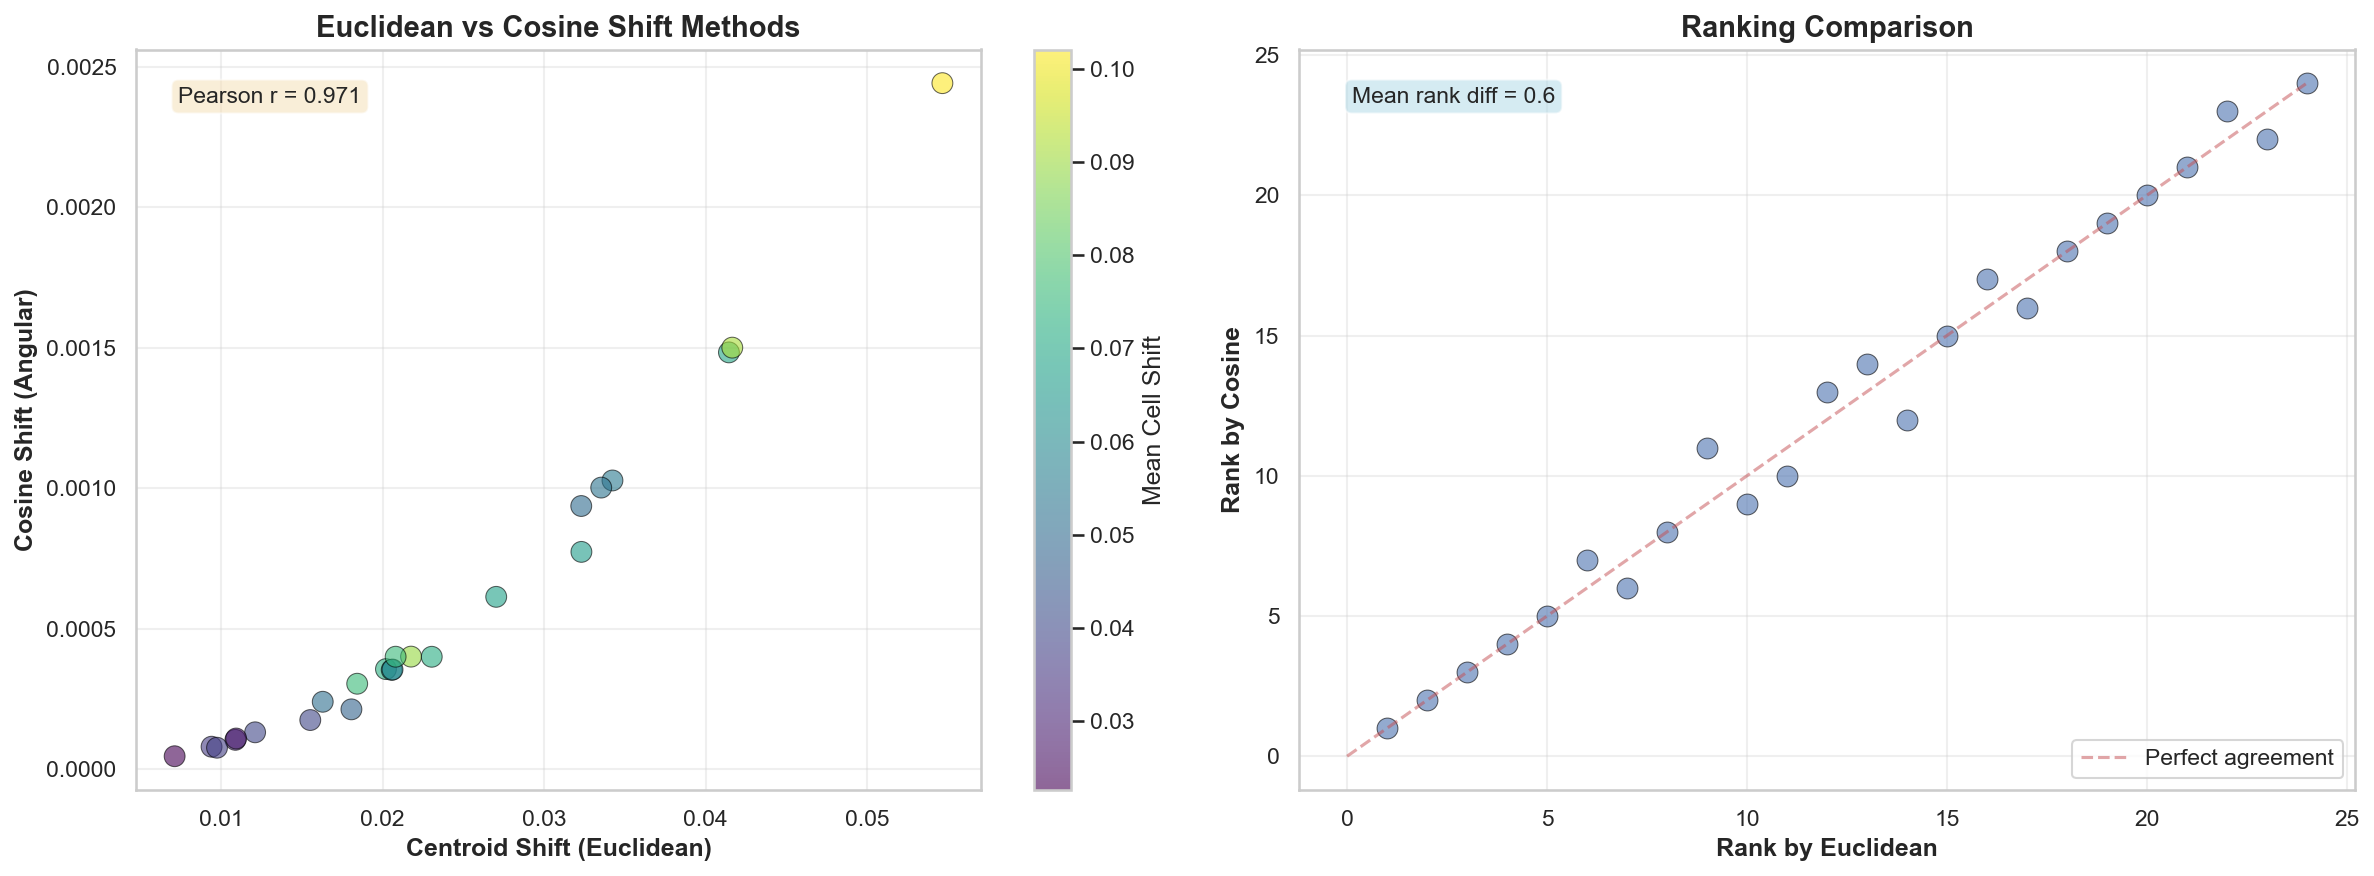

   Saved: method_comparison.png


In [12]:
# Visualization 2: Euclidean vs Cosine Comparison
print("\n2. Comparing Euclidean vs Cosine methods...")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Scatter plot
scatter = axes[0].scatter(
    full_results['centroid_shift'], 
    full_results['cosine_shift'],
    c=full_results['mean_cell_shift'], 
    cmap='viridis', s=100, alpha=0.6, 
    edgecolors='black', linewidth=0.5
)
axes[0].set_xlabel('Centroid Shift (Euclidean)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Cosine Shift (Angular)', fontsize=12, fontweight='bold')
axes[0].set_title('Euclidean vs Cosine Shift Methods', fontsize=14, fontweight='bold')
axes[0].grid(alpha=0.3)
plt.colorbar(scatter, ax=axes[0], label='Mean Cell Shift')
axes[0].text(0.05, 0.95, f'Pearson r = {corr:.3f}', transform=axes[0].transAxes, 
            fontsize=11, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Ranking comparison
full_results['rank_centroid'] = full_results['centroid_shift'].rank(ascending=False)
full_results['rank_cosine'] = full_results['cosine_shift'].rank(ascending=False)
rank_diff = (full_results['rank_centroid'] - full_results['rank_cosine']).abs()

axes[1].scatter(full_results['rank_centroid'], full_results['rank_cosine'],
               s=100, alpha=0.6, edgecolors='black', linewidth=0.5)
axes[1].plot([0, len(full_results)], [0, len(full_results)], 'r--', 
            alpha=0.5, label='Perfect agreement')
axes[1].set_xlabel('Rank by Euclidean', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Rank by Cosine', fontsize=12, fontweight='bold')
axes[1].set_title('Ranking Comparison', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3)
axes[1].legend()
axes[1].text(0.05, 0.95, f'Mean rank diff = {rank_diff.mean():.1f}', 
            transform=axes[1].transAxes, fontsize=11, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'method_comparison.png', dpi=150, bbox_inches='tight')
plt.show()
print("   Saved: method_comparison.png")


3. Cell trajectory visualization (top perturbation)...


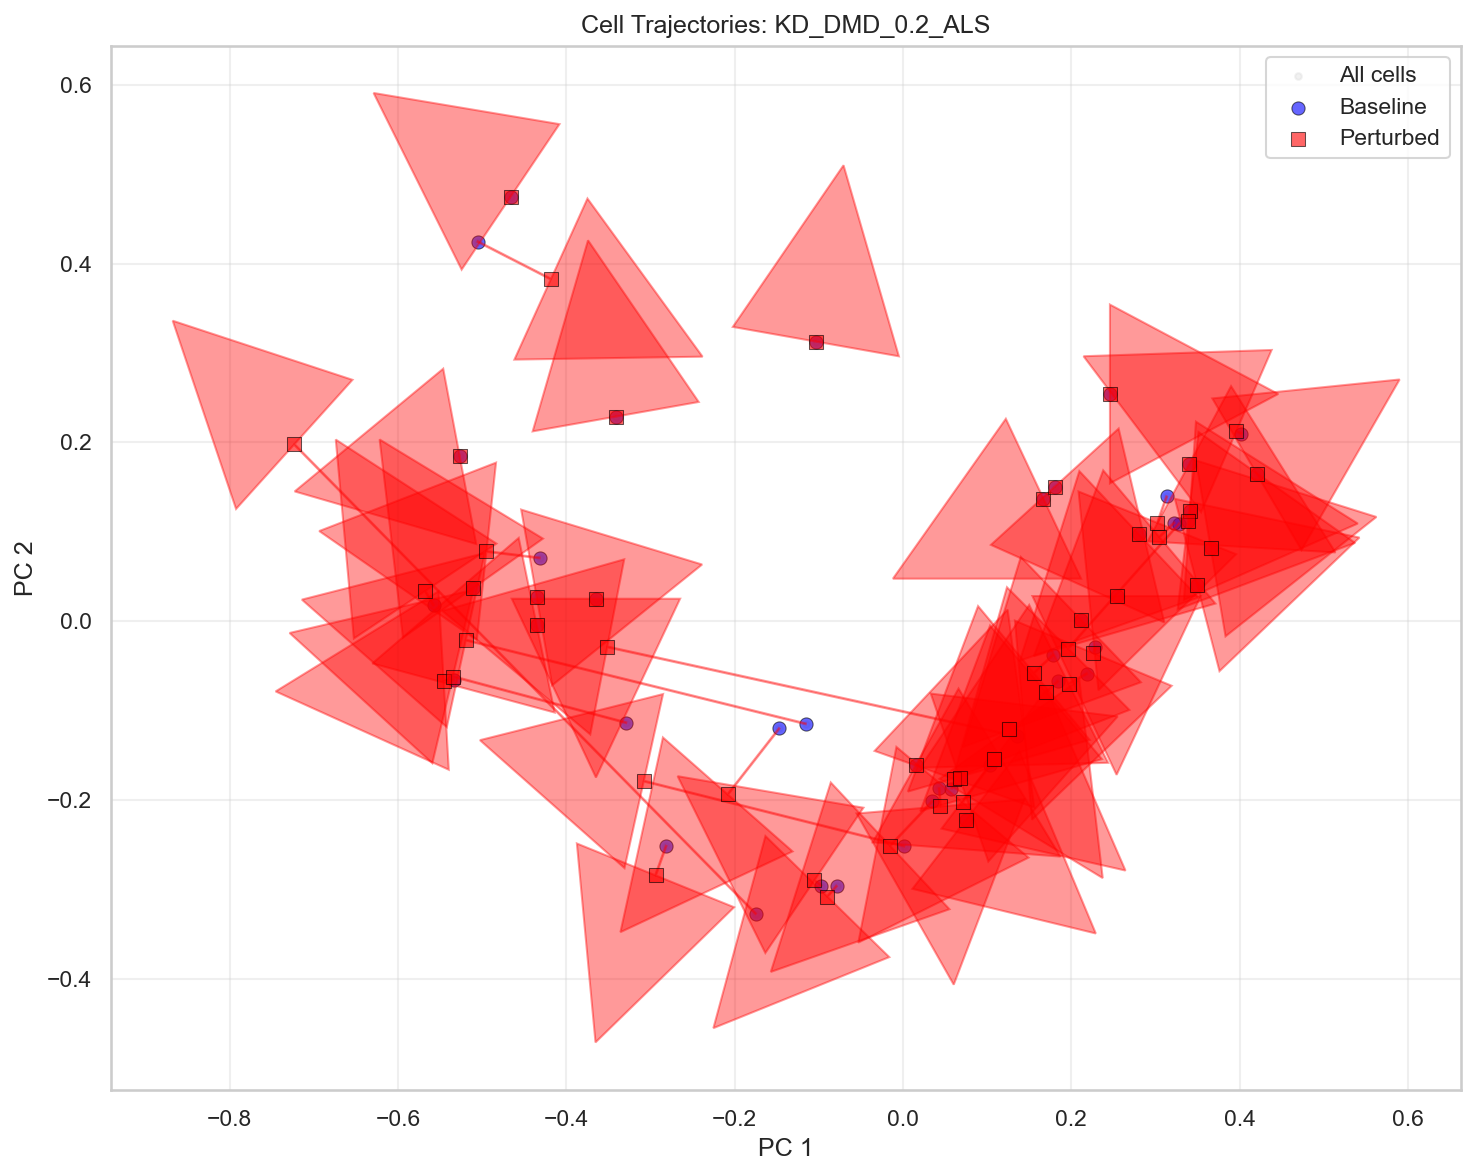

   Saved: shift_vectors.png


In [13]:
# Visualization 3: Shift vectors for top perturbation
print("\n3. Cell trajectory visualization (top perturbation)...")

top_pert = full_results.nlargest(1, 'centroid_shift').iloc[0]
pert_id = top_pert['perturbation_id']

fig = viz.plot_shift_vectors(
    baseline_embeddings, perturbation_embeddings[pert_id],
    n_sample=50, method='pca',
    title=f"Cell Trajectories: {pert_id}"
)
plt.savefig(FIGURES_DIR / 'shift_vectors.png', dpi=150, bbox_inches='tight')
plt.show()
print("   Saved: shift_vectors.png")


4. Disease rescue visualization...


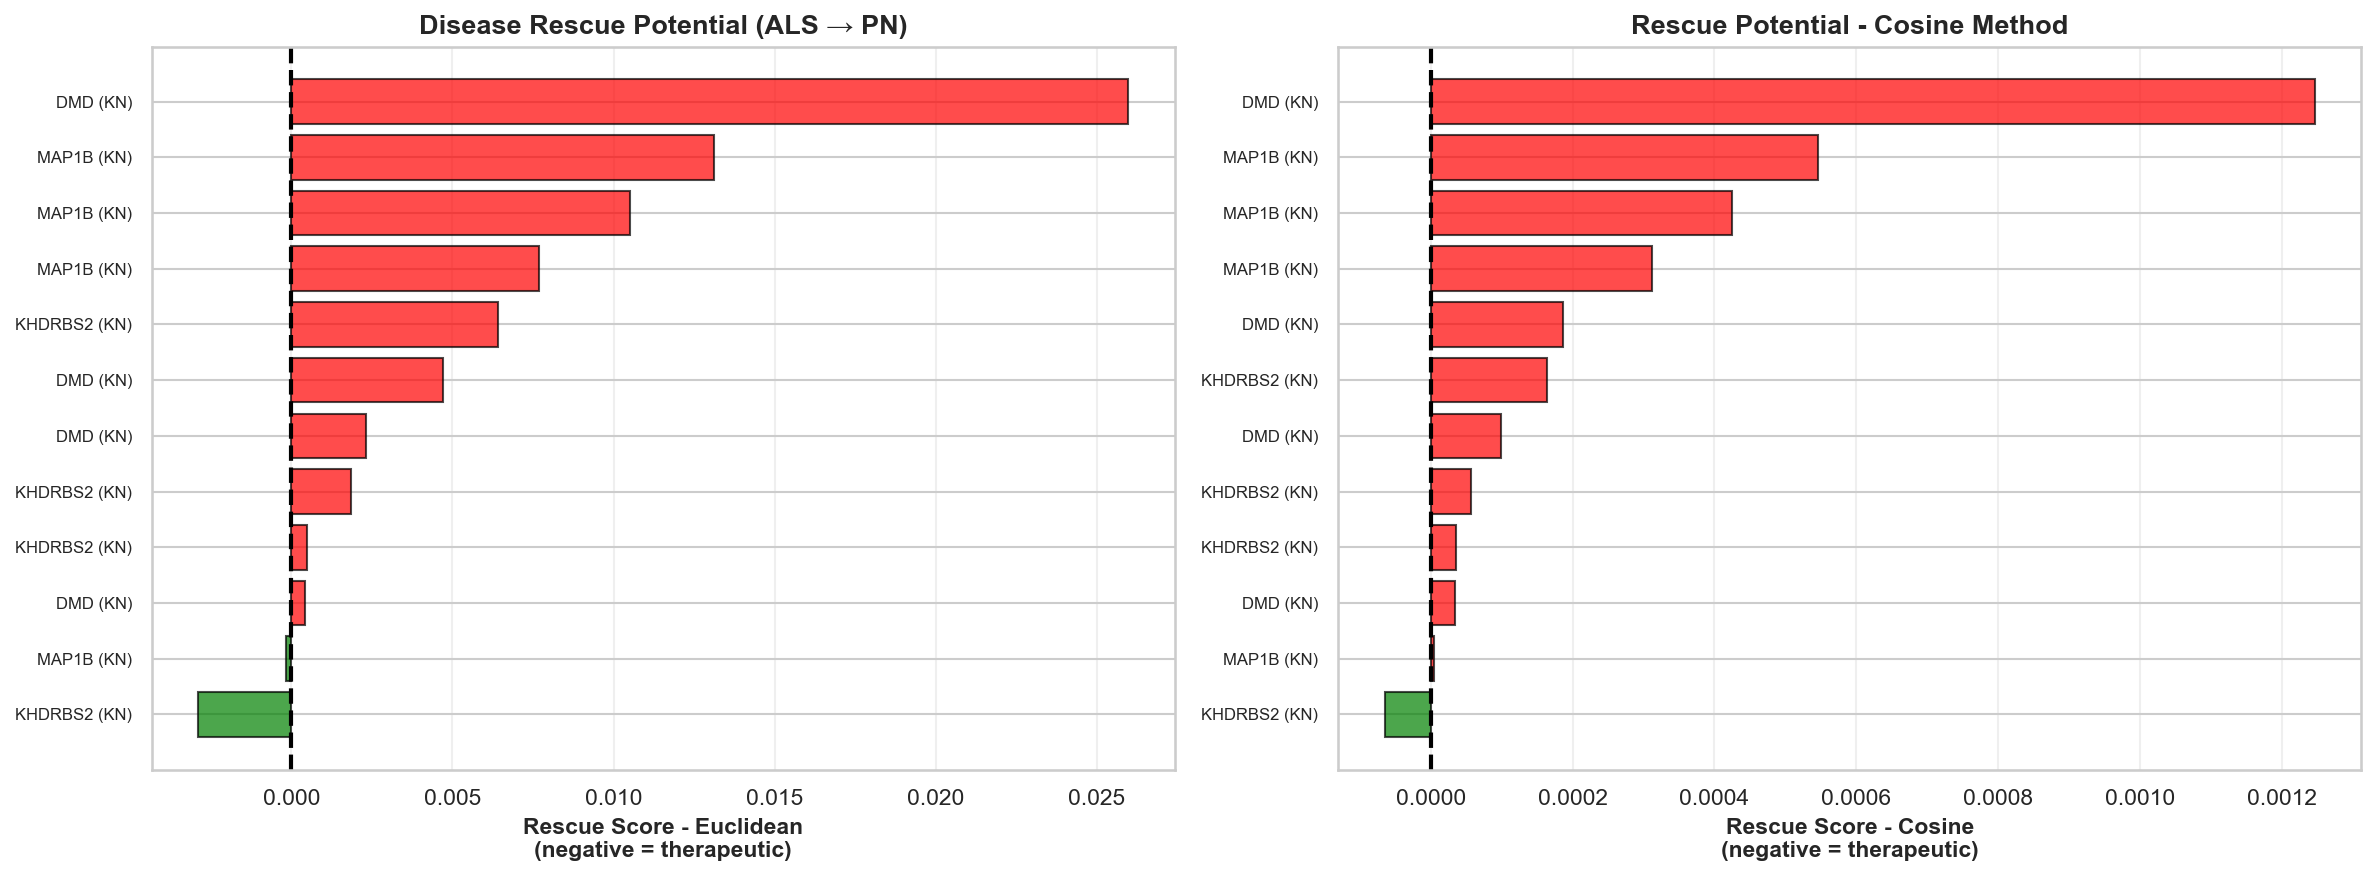

   Saved: disease_rescue.png


In [14]:
# Visualization 4: Disease rescue potential
print("\n4. Disease rescue visualization...")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Euclidean rescue
rescue_sorted = rescue_df.sort_values('rescue_score')
colors = ['green' if x else 'red' for x in rescue_sorted['moves_toward_healthy']]
axes[0].barh(range(len(rescue_sorted)), rescue_sorted['rescue_score'], 
            color=colors, alpha=0.7, edgecolor='black')
axes[0].axvline(0, color='black', linestyle='--', linewidth=2)
axes[0].set_yticks(range(len(rescue_sorted)))
axes[0].set_yticklabels([f"{r['gene']} ({r['type'][:2].upper()})" 
                         for _, r in rescue_sorted.iterrows()], fontsize=8)
axes[0].set_xlabel('Rescue Score - Euclidean\n(negative = therapeutic)', 
                   fontsize=11, fontweight='bold')
axes[0].set_title('Disease Rescue Potential (ALS → PN)', fontsize=13, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)

# Cosine rescue
rescue_sorted_cos = rescue_df.sort_values('rescue_score_cosine')
colors_cos = ['green' if r < 0 else 'red' for r in rescue_sorted_cos['rescue_score_cosine']]
axes[1].barh(range(len(rescue_sorted_cos)), rescue_sorted_cos['rescue_score_cosine'], 
            color=colors_cos, alpha=0.7, edgecolor='black')
axes[1].axvline(0, color='black', linestyle='--', linewidth=2)
axes[1].set_yticks(range(len(rescue_sorted_cos)))
axes[1].set_yticklabels([f"{r['gene']} ({r['type'][:2].upper()})" 
                         for _, r in rescue_sorted_cos.iterrows()], fontsize=8)
axes[1].set_xlabel('Rescue Score - Cosine\n(negative = therapeutic)', 
                   fontsize=11, fontweight='bold')
axes[1].set_title('Rescue Potential - Cosine Method', fontsize=13, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'disease_rescue.png', dpi=150, bbox_inches='tight')
plt.show()
print("   Saved: disease_rescue.png")

In [15]:
# Visualization 5: Comprehensive summary (6-panel figure)
print("\n5. Comprehensive summary...")

# Figure setup
fig = plt.figure(figsize=(22, 10))
gs = fig.add_gridspec(2, 3, hspace=0.35, wspace=0.35, 
                      top=0.93, bottom=0.08, left=0.06, right=0.98)
type_colors = {'knock_down': 'steelblue', 'knock_up': 'coral'}

# Row 1, Col 1: Euclidean distribution
ax1 = fig.add_subplot(gs[0, 0])
for ptype in full_results['type'].unique():
    data = full_results[full_results['type'] == ptype]['centroid_shift']
    ax1.hist(data, alpha=0.6, label=ptype.replace('_', ' ').title(), bins=15, 
             edgecolor='black', color=type_colors.get(ptype, 'gray'), linewidth=1.2)
ax1.set_xlabel('Centroid Shift (Euclidean)', fontweight='bold', fontsize=12)
ax1.set_ylabel('Frequency', fontweight='bold', fontsize=12)
ax1.set_title('Shifts by Type', fontweight='bold', fontsize=14, pad=10)
ax1.legend(framealpha=0.9, fontsize=11)
ax1.grid(alpha=0.3)

# Row 1, Col 2: Cosine distribution
ax2 = fig.add_subplot(gs[0, 1])
for ptype in full_results['type'].unique():
    data = full_results[full_results['type'] == ptype]['cosine_shift']
    ax2.hist(data, alpha=0.6, label=ptype.replace('_', ' ').title(), bins=15, 
             edgecolor='black', color=type_colors.get(ptype, 'gray'), linewidth=1.2)
ax2.set_xlabel('Cosine Shift', fontweight='bold', fontsize=12)
ax2.set_ylabel('Frequency', fontweight='bold', fontsize=12)
ax2.set_title('Cosine Shifts by Type', fontweight='bold', fontsize=14, pad=10)
ax2.legend(framealpha=0.9, fontsize=11)
ax2.grid(alpha=0.3)

# Row 1, Col 3: Method comparison
ax3 = fig.add_subplot(gs[0, 2])
ax3.scatter(full_results['centroid_shift'], full_results['cosine_shift'],
           alpha=0.5, edgecolors='black', linewidth=0.5, s=70)
ax3.set_xlabel('Euclidean Shift', fontweight='bold', fontsize=12)
ax3.set_ylabel('Cosine Shift', fontweight='bold', fontsize=12)
ax3.set_title(f'Method Comparison (r={corr:.3f})', fontweight='bold', fontsize=14, pad=10)
ax3.grid(alpha=0.3)

# Row 2, Col 1: Movement vs Structure
ax4 = fig.add_subplot(gs[1, 0])
scatter = ax4.scatter(full_results['centroid_shift'], full_results['neighborhood_preservation'],
                     c=full_results['mean_cell_shift'], cmap='viridis',
                     s=120, alpha=0.6, edgecolors='black', linewidth=0.5)
ax4.set_xlabel('Centroid Shift', fontweight='bold', fontsize=12)
ax4.set_ylabel('Neighborhood Preservation', fontweight='bold', fontsize=12)
ax4.set_title('Movement vs Structure Preservation', fontweight='bold', fontsize=14, pad=10)
ax4.grid(alpha=0.3)
cbar = plt.colorbar(scatter, ax=ax4, shrink=0.8)
cbar.set_label('Mean Cell Shift', fontweight='bold', fontsize=11)

# Row 2, Col 2: Top 5 Euclidean
ax5 = fig.add_subplot(gs[1, 1])
top_5_euc = full_results.nlargest(5, 'centroid_shift').copy()
top_5_euc['type_label'] = top_5_euc['perturbation_id'].str.extract(r'^(KD|KU)_')[0].fillna('KD')
top_5_euc['factor'] = top_5_euc['perturbation_id'].str.extract(r'_(\d+\.?\d*)_')[0].fillna('1.0')
top_5_euc['label'] = top_5_euc['type_label'] + '_' + top_5_euc['gene'].str[:10] + '_' + top_5_euc['factor']
y_pos = np.arange(len(top_5_euc))
colors_bars = [type_colors['knock_down'] if 'KD' in str(t) else type_colors['knock_up'] 
               for t in top_5_euc['type_label']]
ax5.barh(y_pos, top_5_euc['centroid_shift'], alpha=0.7, color=colors_bars, 
        edgecolor='black', linewidth=1.2)
ax5.set_yticks(y_pos)
ax5.set_yticklabels(top_5_euc['label'], fontsize=11)
ax5.set_xlabel('Euclidean Shift', fontweight='bold', fontsize=12)
ax5.set_title('Top 5 by Euclidean', fontweight='bold', fontsize=14, pad=10)
ax5.grid(axis='x', alpha=0.3)

# Row 2, Col 3: Top 5 Cosine
ax6 = fig.add_subplot(gs[1, 2])
top_5_cos = full_results.nlargest(5, 'cosine_shift').copy()
top_5_cos['type_label'] = top_5_cos['perturbation_id'].str.extract(r'^(KD|KU)_')[0].fillna('KD')
top_5_cos['factor'] = top_5_cos['perturbation_id'].str.extract(r'_(\d+\.?\d*)_')[0].fillna('1.0')
top_5_cos['label'] = top_5_cos['type_label'] + '_' + top_5_cos['gene'].str[:10] + '_' + top_5_cos['factor']
y_pos = np.arange(len(top_5_cos))
colors_bars = [type_colors['knock_down'] if 'KD' in str(t) else type_colors['knock_up'] 
               for t in top_5_cos['type_label']]
ax6.barh(y_pos, top_5_cos['cosine_shift'], alpha=0.7, color=colors_bars, 
        edgecolor='black', linewidth=1.2)
ax6.set_yticks(y_pos)
ax6.set_yticklabels(top_5_cos['label'], fontsize=11)
ax6.set_xlabel('Cosine Shift', fontweight='bold', fontsize=12)
ax6.set_title('Top 5 by Cosine', fontweight='bold', fontsize=14, pad=10)
ax6.grid(axis='x', alpha=0.3)

plt.suptitle('Task 3: Embedding Space Analysis', fontsize=20, fontweight='bold', y=0.97)
plt.savefig(FIGURES_DIR / 'comprehensive_summary.png', dpi=150, bbox_inches='tight')
plt.close()
print("   Saved: comprehensive_summary.png")

print("\nAll visualizations complete")


5. Comprehensive summary...
   Saved: comprehensive_summary.png

All visualizations complete


## 7. Summary Report

In [16]:
print("\n" + "="*70)
print("TASK 3 SUMMARY")
print("="*70)

# Key findings
best_euc = full_results.nlargest(1, 'centroid_shift').iloc[0]
best_cos = full_results.nlargest(1, 'cosine_shift').iloc[0]
best_rescue = rescue_df.nsmallest(1, 'rescue_score').iloc[0] if not rescue_df.empty else None

print(f"\nDataset:")
print(f"  Embedding dimension: {baseline_embeddings.shape[1]}")
print(f"  Cells analyzed: {baseline_embeddings.shape[0]:,}")
print(f"  Perturbations: {len(full_results)}")
print(f"  ALS perturbations: {len(rescue_df)}")

print(f"\nMethods Agreement:")
print(f"  Pearson correlation (Euc vs Cos): {corr:.3f}")
print(f"  Mean rank difference: {rank_diff.mean():.1f}")

print(f"\nTop Perturbation (Euclidean):")
print(f"  {best_euc['perturbation_id']}")
print(f"  Euclidean shift: {best_euc['centroid_shift']:.4f}")
print(f"  Cosine shift: {best_euc['cosine_shift']:.4f}")

print(f"\nTop Perturbation (Cosine):")
print(f"  {best_cos['perturbation_id']}")
print(f"  Euclidean shift: {best_cos['centroid_shift']:.4f}")
print(f"  Cosine shift: {best_cos['cosine_shift']:.4f}")

if best_rescue is not None:
    print(f"\nBest Rescue Candidate:")
    print(f"  {best_rescue['perturbation_id']}")
    print(f"  Euclidean rescue: {best_rescue['rescue_score']:.4f}")
    print(f"  Cosine rescue: {best_rescue['rescue_score_cosine']:.4f}")

print(f"\nOutputs:")
print(f"  {TABLES_DIR}/")
print(f"    - embedding_metrics.csv")
print(f"    - disease_rescue_analysis.csv")
print(f"    - full_analysis.csv")
print(f"  {FIGURES_DIR}/")
print(f"    - metrics_heatmap.png")
print(f"    - method_comparison.png")
print(f"    - shift_vectors.png")
print(f"    - disease_rescue.png")
print(f"    - comprehensive_summary.png")

print(f"\nNext: Task 4 - Prioritize therapeutic targets")


TASK 3 SUMMARY

Dataset:
  Embedding dimension: 512
  Cells analyzed: 50
  Perturbations: 24
  ALS perturbations: 12

Methods Agreement:
  Pearson correlation (Euc vs Cos): 0.971
  Mean rank difference: 0.6

Top Perturbation (Euclidean):
  KD_DMD_0.2_ALS
  Euclidean shift: 0.0547
  Cosine shift: 0.0024

Top Perturbation (Cosine):
  KD_DMD_0.2_ALS
  Euclidean shift: 0.0547
  Cosine shift: 0.0024

Best Rescue Candidate:
  KD_KHDRBS2_0.5_ALS
  Euclidean rescue: -0.0029
  Cosine rescue: -0.0001

Outputs:
  /Users/lubainakothari/Desktop/perturbation_newstructure/results/task3/tables/
    - embedding_metrics.csv
    - disease_rescue_analysis.csv
    - full_analysis.csv
  /Users/lubainakothari/Desktop/perturbation_newstructure/results/task3/figures/
    - metrics_heatmap.png
    - method_comparison.png
    - shift_vectors.png
    - disease_rescue.png
    - comprehensive_summary.png

Next: Task 4 - Prioritize therapeutic targets
